In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from datasets import load_dataset
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Loading the dataset

In [ ]:
dataset = load_dataset('csv', data_files='sambodhan_balanced_dataset.csv', split='train')


In [ ]:
df = pd.read_csv('sambodhan_balanced_dataset.csv')

In [ ]:
df.info()

In [ ]:
df.department.value_counts()

In [ ]:
# removing the urgency column

dataset = dataset.remove_columns(['urgency'])

In [ ]:
dataset

# preprocessing and cleaning

In [ ]:
import re

# mapping the urgency and the dept_label

department2id = {
       'Municipal Governance & Community Services': 0 ,
       'Education, Health & Social Welfare': 1,
       'Infrastructure, Utilities & Natural Resources':2,
       'Security & Law Enforcement':3
}


id2department = {
    0 : 'Municipal Governance & Community Services',
    1 : 'Education, Health & Social Welfare',
    2 : 'Infrastructure, Utilities & Natural Resources',
    3 : 'Security & Law Enforcement'
}



def clean_and_encode_grievance(example):
    # 1. Remove URLs (Pure Noise)
    example['grievance'] = re.sub(r'https?://\S+|www\.\S+', '', example['grievance'])

    # 2. Remove HTML Tags (Pure Noise)
    example['grievance'] = re.sub(r'<.*?>', '', example['grievance'])

    # 3. Normalize Whitespace (For consistency)
    # Replace newlines with space, then reduce all multiple spaces to a single space, and strip edges
    example['grievance'] = re.sub(r'\n', ' ', example['grievance'])
    example['grievance'] = re.sub(r'\s+', ' ', example['grievance']).strip()

    # mapping the dept_label , urgency_label
    example['label'] = department2id[example['department']]




    # Keep the original character casing, punctuation, numbers, and emojis.
    return example



In [ ]:
dataset = dataset.map(clean_and_encode_grievance).remove_columns(['department'])

dataset

In [ ]:
# counting the no. of dept_label
dept_labels = dataset['label']
print(pd.Series(dept_labels).value_counts())

# hf-login

In [ ]:
from huggingface_hub import login
from google.colab import userdata

hf_token = userdata.get('hf-access')

login(hf_token)

# Loading model and tokenizers

In [ ]:
!pip install -U bitsandbytes transformers datasets accelerate peft


In [ ]:
from transformers import (
    AutoTokenizer, DataCollatorWithPadding,
    AutoModelForSequenceClassification,TrainingArguments,
    Trainer, EarlyStoppingCallback,
    BitsAndBytesConfig
)





model_checkpoint ="xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(id2department),
    id2label=id2department,
    label2id=department2id
)




In [ ]:
peft_model.print_trainable_parameters()

# tokenizing the dataset

In [ ]:
# tokenizing the dataset

def tokenize_function(examples):
    return tokenizer(examples["grievance"], truncation=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True).remove_columns(['grievance'])

# Train, Test, and Validation Splits

In [ ]:
# train, test, and validation splits the datset

train_test_split = tokenized_dataset.shuffle(seed=42).train_test_split(test_size=0.2, seed=42)
train_dataset = train_test_split['train']
test_eval_split = train_test_split['test'].train_test_split(test_size=0.5, seed=42)
test_dataset = test_eval_split['train']
eval_dataset = test_eval_split['test']

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
eval_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


train_dataset, test_dataset, eval_dataset


# compute metric function

In [ ]:
!pip install evaluate

In [ ]:
# import numpy as np
# import evaluate

# accuracy = evaluate.load("accuracy")
# f1 = evaluate.load("f1")
# precision = evaluate.load("precision")
# recall = evaluate.load("recall")

# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     predictions = np.argmax(logits, axis=-1)

#     results = {}
#     results.update(accuracy.compute(predictions=predictions, references=labels))
#     results.update(f1.compute(predictions=predictions, references=labels, average="macro"))
#     results.update(precision.compute(predictions=predictions, references=labels, average="macro"))
#     results.update(recall.compute(predictions=predictions, references=labels, average="macro"))

#     return results

import numpy as np
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    results = {
        "accuracy": accuracy_score(labels, predictions),
        "f1_macro": f1_score(labels, predictions, average="macro", zero_division=0),
        "f1_weighted": f1_score(labels, predictions, average="weighted", zero_division=0),
        "precision_macro": precision_score(labels, predictions, average="macro", zero_division=0),
        "recall_macro": recall_score(labels, predictions, average="macro", zero_division=0),
        "precision_weighted": precision_score(labels, predictions, average="weighted", zero_division=0),
        "recall_weighted": recall_score(labels, predictions, average="weighted", zero_division=0)
    }

    return results





# Training Arguments

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    # output_dir="yelp_review_classifier",
    eval_strategy="steps",
    eval_steps=50,
    # save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,

    hub_model_id='mr-kush/sambodhan-department-classification-model',
    push_to_hub=False,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    fp16=True,
    report_to="none",

    logging_dir='./logs',
    logging_steps=50,


)

# early stopping criteria
early_stopping = EarlyStoppingCallback(
                                early_stopping_patience=2,
                                early_stopping_threshold=0.001
                                )

# Handling the Class imbalance: FocalLoss

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLossMultiClass(nn.Module):
    def __init__(self, gamma=2, alpha=0.25, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, logits, targets):
        ce_loss = F.cross_entropy(logits, targets, reduction='none')  # [batch]
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


# Custom FocalLossTrainer

In [ ]:
# Custom Trainer
class FocalLossTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # self.class_weights = class_weights.to(self.model.device)

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        loss_fct = FocalLossMultiClass()
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss


# Full-Parameter Finetunning

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(id2department),
    id2label=id2department,
    label2id=department2id,
)



trainer = FocalLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,

    compute_metrics=compute_metrics,
    callbacks=[early_stopping],
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    processing_class=tokenizer

)


In [ ]:
trainer.train()

In [ ]:
trainer.evaluate(test_dataset)


# Evaluating the model output.

In [ ]:
model_predictions =  trainer.predict(test_dataset)

In [ ]:
# visualising using the sklearn classification metrices

from sklearn.metrics import classification_report

y_true = model_predictions.label_ids
y_pred = np.argmax(model_predictions.predictions, axis=-1)

print(classification_report(y_true, y_pred, target_names=id2department.values()))

In [ ]:
# visualising the confusion metrices

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 8))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=id2department.values(), yticklabels=id2department.values())

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Peft model Training

In [ ]:
import torch
from peft import LoraConfig, get_peft_model, TaskType



new_model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(id2department),
    id2label=id2department,
    label2id=department2id,
)

peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=16,                     # increase capacity
    lora_alpha=16,             # stable scaling
    lora_dropout=0.05,         # mild regularization
    inference_mode=False,
    target_modules = ["query", "value","key", "intermediate.dense", "output.dense"]  # efficient fine-tuning
)

peft_model = get_peft_model(new_model, peft_config)





peft_trainer = FocalLossTrainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,

    compute_metrics=compute_metrics,
    callbacks=[early_stopping],
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    processing_class=tokenizer

)


In [ ]:
peft_model.print_trainable_parameters()

In [ ]:
peft_trainer.train()

# Pushing the model to the hub

In [ ]:
repo_name = "mr-kush/sambodhan-department-classification-model"

trainer.push_to_hub(commit_message="include the tokenizer class")


In [ ]:
model.config

In [ ]:
# Empty VRAM
del model
del pipe
del trainer
import gc
gc.collect()
gc.collect()

# Testing the Scripts

In [ ]:
from clean_and_preprocess import preprocess_pipeline
import pandas as pd
df = pd.read_csv('sambodhan_balanced_dataset.csv')

dataset = preprocess_pipeline(
    df = df,
    label_column = 'department',
    train_size=0.8,
    val_size=0.1,
    test_size=0.1
)

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['grievance', 'label'],
        num_rows: 4800
    })
    eval: Dataset({
        features: ['grievance', 'label'],
        num_rows: 600
    })
    test: Dataset({
        features: ['grievance', 'label'],
        num_rows: 600
    })
})

In [ ]:
from train_model import  GrievanceClassifier
from google.colab import userdata

hf_token = userdata.get('hf-access')

department2id = {
       'Municipal Governance & Community Services': 0 ,
       'Education, Health & Social Welfare': 1,
       'Infrastructure, Utilities & Natural Resources':2,
       'Security & Law Enforcement':3
}


id2department = {
    0 : 'Municipal Governance & Community Services',
    1 : 'Education, Health & Social Welfare',
    2 : 'Infrastructure, Utilities & Natural Resources',
    3 : 'Security & Law Enforcement'
}


classifier = GrievanceClassifier(
    model_checkpoint="xlm-roberta-base",
    num_labels=len(department2id),
    id2label=id2department,
    label2id=department2id,
    hf_token= hf_token
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
classifier.train(
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    hf_training_args={
        "push_to_hub": True,
        "hub_model_id": "mr-kush/sambodhan-department-classification-model",
    }
)


Map:   0%|          | 0/4800 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,Precision Macro,Recall Macro,Precision Weighted,Recall Weighted
50,0.145000,0.050669,0.863333,0.847535,0.856331,0.858385,0.855782,0.865528,0.863333
100,0.046600,0.018590,0.953333,0.954484,0.953462,0.960805,0.949268,0.954814,0.953333
150,0.022700,0.022912,0.940000,0.939358,0.940396,0.936056,0.943682,0.941931,0.940000
200,0.012700,0.015926,0.955000,0.956443,0.955822,0.954625,0.960648,0.958928,0.955000
250,0.016000,0.013270,0.965000,0.965872,0.964963,0.966650,0.965134,0.964966,0.965000
300,0.012200,0.011709,0.961667,0.962486,0.961562,0.960261,0.965094,0.961865,0.961667
350,0.010600,0.009400,0.966667,0.965867,0.966562,0.966433,0.965486,0.966617,0.966667


Parameter 'function'=<function GrievanceClassifier.tokenize_dataset.<locals>.tokenize_function at 0x7975e2866a20> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/600 [00:00<?, ? examples/s]


Classification Report:

                                               precision    recall  f1-score   support

    Municipal Governance & Community Services       0.95      0.92      0.94       126
           Education, Health & Social Welfare       0.99      0.99      0.99       129
Infrastructure, Utilities & Natural Resources       0.96      0.98      0.97       131
                   Security & Law Enforcement       0.97      0.97      0.97       214

                                     accuracy                           0.97       600
                                    macro avg       0.97      0.97      0.97       600
                                 weighted avg       0.97      0.97      0.97       600



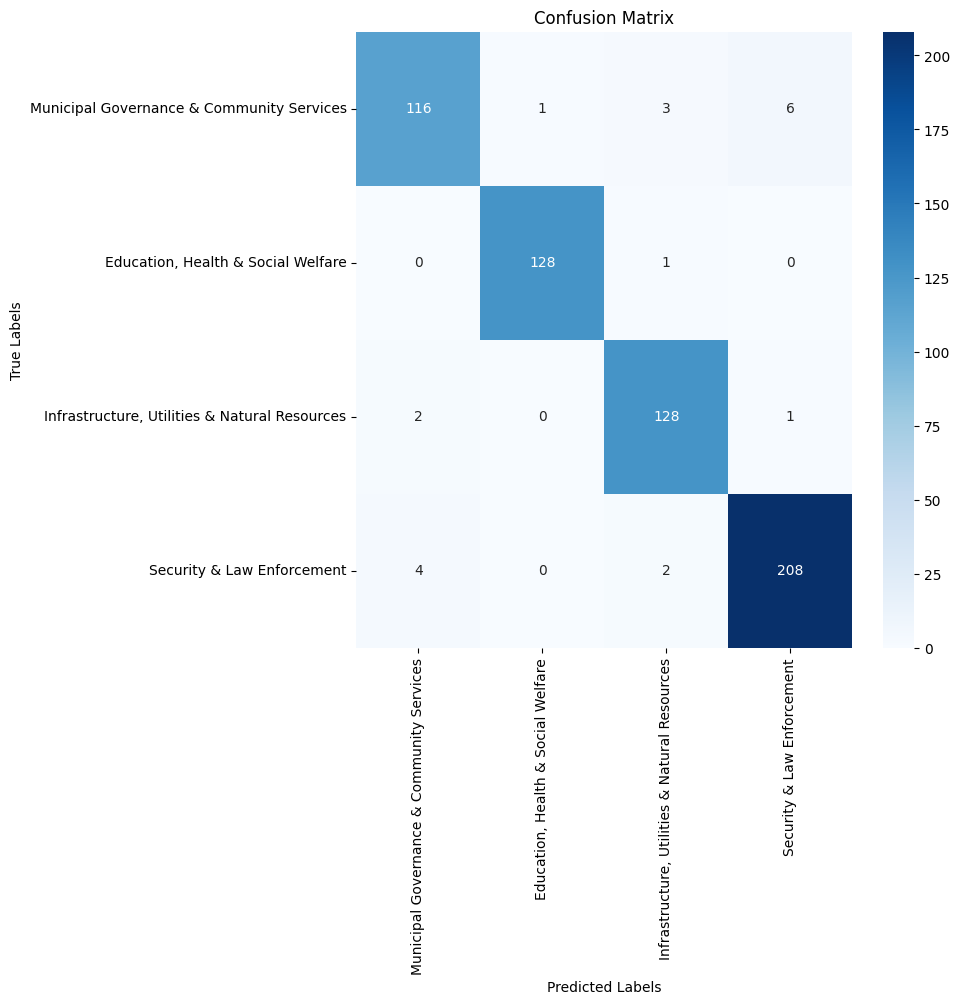

In [ ]:
predictions, cm = classifier.evaluate(dataset['test'])

In [ ]:
# pushing to hub

classifier.push_model_to_hub(
    hub_model_id="mr-kush/sambodhan-department-classification-model",
    commit_message="include the tokenizer class",
    use_trainer=True
)

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...t/sentencepiece.bpe.model: 100%|##########| 5.07MB / 5.07MB            

  ...ner_output/tokenizer.json: 100%|##########| 17.1MB / 17.1MB            

  ..._output/model.safetensors:   1%|          | 8.41MB / 1.11GB            

  ..._output/training_args.bin:  10%|9         |   575B / 5.84kB            

Trainer (with model + tokenizer) pushed to mr-kush/sambodhan-department-classification-model


# Inferencing the model

In [ ]:
from transformers import pipeline

# Load the fine-tuned model
pipe = pipeline(
    "text-classification",
    model="mr-kush/sambodhan-department-classification-model",
    top_k = None
)

text = "The road in my neighborhood is damaged and needs repair."

# Get probability scores for all classes
results = pipe(text)

print(results)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

Device set to use cuda:0


[[{'label': 'Infrastructure, Utilities & Natural Resources', 'score': 0.915102481842041}, {'label': 'Municipal Governance & Community Services', 'score': 0.04293778911232948}, {'label': 'Security & Law Enforcement', 'score': 0.03349008783698082}, {'label': 'Education, Health & Social Welfare', 'score': 0.008469599299132824}]]


In [ ]:
ip_grievance="हाम्रो गाउँपालिकाको प्राथमिक स्वास्थ्य केन्द्रमा एक महिनादेखि सामान्य चेक-अप सेवा पनि उपलब्ध छैन। स्वास्थ्यकर्मीहरू नियमित उपस्थित नहुने र औषधिको भण्डारण लगभग शून्य भन्ने अवस्था देखिएको छ। बिरामीहरू नजिकको जिल्ला अस्पतालसम्म पुग्न यातायात खर्च र समय दुबै अधिक लाग्ने भएपछि, सामान्य रोगहरु पनि बिग्रिने दृष्टान्त देखिएको छ। यसले स्वास्थ्य प्रणालीमाथि आम विश्वासलाई कमजोर पारिरहेको छ। स्वास्थ्य कार्यालय र स्थानीय सरकारले तुरुन्त रोग निवारणका लागि कर्मचारी र औषधि व्यवस्था पुनर्स्थापना गरिदिनुहोला।"

In [ ]:
from predict_dept import DepartmentPredictor

dept_pipeline = DepartmentPredictor()



Device set to use cuda:0


In [ ]:
%%time
dept_pipeline.predict(ip_grievance)

CPU times: user 21.5 ms, sys: 0 ns, total: 21.5 ms
Wall time: 24.2 ms


{'label': 'Education, Health & Social Welfare',
 'confidence': 0.9477,
 'scores': {'Education, Health & Social Welfare': 0.9477,
  'Municipal Governance & Community Services': 0.0407,
  'Infrastructure, Utilities & Natural Resources': 0.0074,
  'Security & Law Enforcement': 0.0042}}

In [ ]:
# torch version

import torch

print(torch.__version__)

2.8.0+cu126
